# 🐕🐱 Dog vs Cat Classification with PyTorch & MLflow/GCP
---
This notebook demonstrates a complete machine learning pipeline for binary image classification:

- What we'll build:
    - **Simple CNN**: Baseline model from scratch
    - **Improved CNN**: With BatchNorm & Dropout for better performance  
    - **VGG16**: Transfer learning with pre-trained ImageNet weights
    - **VGG16 + Fine-tuning**: With data augmentation and layer unfreezing
    - **MobileNetV2**: Efficient mobile-optimized architecture

- **Requirements:**
    * 🐳 **Docker**: NVIDIA PyTorch container (`nvcr.io/nvidia/pytorch:25.06-py3`)
    * ⚙️ **Hardware**: GPU required
    * 🔗 **GCP MLflow**: MLflow server running on GCP VM for experiment tracking
    * 🛠️ **Tools**: Docker, WSL2, uv package manager

- **Level**: Advanced Data Science

- **🎯 Goals** : Find the best CNN model that suits our dataset by comparing architectures, fine-tuning parameters, and applying data augmentation for optimal performance.

- Key features:
    - 🎯 **MLflow tracking**: All experiments logged to GCP for comparison
    - 📊 **Professional evaluation**: Confusion matrices, classification reports
    - 🔄 **Early stopping**: Prevent overfitting automatically
    - 📈 **Visualization**: Training curves and sample predictions

Let's build and compare 5 different approaches to solve this classic computer vision problem!

---
🚀 Quick Start
```bash
# Build and run PyTorch environment
make dev
```

## Setup and Load Data 🛠📂

### Import Libraries 📚

In [ ]:
# Standard library imports
import collections
import os
import random
from io import BytesIO

# Third-party imports
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

# MLflow imports
import mlflow
import mlflow.pytorch

In [ ]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0)}")

### 🔗 MLflow Connection Setup

In [ ]:
# MLflow Constants
MLFLOW_TRACKING_URI = "http://34.134.188.115:5000" # Replace with your VM IP
USER_NAME = "lisekarimi" # Replace with your username
EXPERIMENT_NAME = "pixdl-dog-cat-classification"

# Set experiment
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Get and print experiment ID
experiment = mlflow.set_experiment("pixdl-dog-cat-classification")
print(f"GCP MLflow Experiment ID: {experiment.experiment_id}")

In [ ]:
# Set the credentials (put your JSON file in the same directory)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './pixdl-468713-key.json'

print("Google Cloud credentials set!")

### Load Data 📥

💡Create  a dataset folder

💡Download: Cats vs Dogs Dataset from Kaggle https://www.kaggle.com/datasets/tongpython/cat-and-dog/data 

💡Unzip archive.zip into the dataset folder

💡Both `training_set` and `test_set` folders should be inside the `dataset` directory, each containing `cats` and `dogs` subfolders with the respective images.


In [ ]:
dataset_path = "datasets/cat_dog"

# Verify Folder Structure
print("Training set contents:", os.listdir(os.path.join(dataset_path, "training_set")))
print("Test set contents:", os.listdir(os.path.join(dataset_path, "test_set")))

In [ ]:
img = Image.open(os.path.join(dataset_path, 'training_set/dogs', 'dog.30.jpg'))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
# Define transforms
transform = transforms.Compose([
   transforms.Resize((256, 256)),
   transforms.ToTensor()
])

# Define dataset directories
train_path = os.path.join(dataset_path, "training_set")
test_path = os.path.join(dataset_path, "test_set")

# Load datasets
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## EDA 🔍

### Data size 📏

In [ ]:
# Count batches and samples
train_batches = len(train_loader)
test_batches = len(test_loader)
train_samples = len(train_dataset)
test_samples = len(test_dataset)

print(f"Training batches: {train_batches}")
print(f"Test batches: {test_batches}")
print(f"Training samples: {train_samples}")
print(f"Test samples: {test_samples}")

In [ ]:
# Take one batch and examine it
for images, labels in train_loader:
   print(f"Batch shape: {images.shape}")
   print(f"Labels shape: {labels.shape}")
   print(f"Image dtype: {images.dtype}")
   print(f"Labels dtype: {labels.dtype}")
   print(f"Image value range: {images.min().item()} to {images.max().item()}")
   print(f"Labels in batch: {labels.numpy()}")
   break  # Only take first batch

### Label Mapping 🏷

In [ ]:
print("Class Names:", train_dataset.classes)

Class labels are assigned alphabetically by default:
- Cat → 0
- Dog → 1

### Display Some Samples 🖼

In [ ]:
def display_samples(dataset, num_samples=10):
    # Get random samples from dataset
    total_samples = len(dataset.dataset)
    random_indices = random.sample(range(total_samples), num_samples)

    plt.figure(figsize=(num_samples * 3, 3))
    for i, idx in enumerate(random_indices):
        image, label = dataset.dataset[idx]
        plt.subplot(1, num_samples, i + 1)
        img = image.permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(dataset.dataset.classes[label])
        plt.axis("off")
    plt.show()

In [ ]:
display_samples(train_loader, num_samples=5)  # Remove batch parameter

### Class Distribution 📈

In [ ]:
# Count occurrences of each label
label_counts = collections.Counter(train_dataset.targets)

# Class names
class_names = train_dataset.classes

# Plot class distribution
plt.bar(class_names, [label_counts[0], label_counts[1]], color=['blue', 'orange'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.show()

# Print counts
print(f"{class_names[0]}: {label_counts[0]} images")
print(f"{class_names[1]}: {label_counts[1]} images")

Our dataset is fairly balanced, so we don’t need to apply special balancing techniques

## Preprocess Data 📦

### Split Data ✂️

In [ ]:
# Print dataset info
print(f"Train dataset size: {len(train_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

In [ ]:
# Define split ratio
train_ratio = 0.8  # 80% training, 20% validation

# Compute split sizes
total_samples = len(train_dataset)
train_size = int(total_samples * train_ratio)
valid_size = total_samples - train_size

# Split dataset
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=False)

# Verify split
print(f"Training: {len(train_data)} samples, {len(train_loader)} batches")
print(f"Validation: {len(valid_data)} samples, {len(valid_loader)} batches")

### Resize and Scale 📏

In [ ]:
# Define preprocessing transforms
transform = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),  # Automatically normalizes to [0,1]
])

# Create new datasets with updated transforms
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Split dataset again with new transforms
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# Create data loaders with num_workers for performance
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Verify with a sample
for image, label in train_loader:
   print(image[0].shape)  # First image in batch
   print(label[0].item())  # First label
   break

Now that we've explored our data, checked out some samples, and split it up, it's time to build our CNN model!

We'll start with a baseline model—a simple CNN to see how well it performs before we fine-tune things. Think of it as our starting point before we dive into optimizations. Let’s get coding! 😃

## Baseline CNN Model 🧠

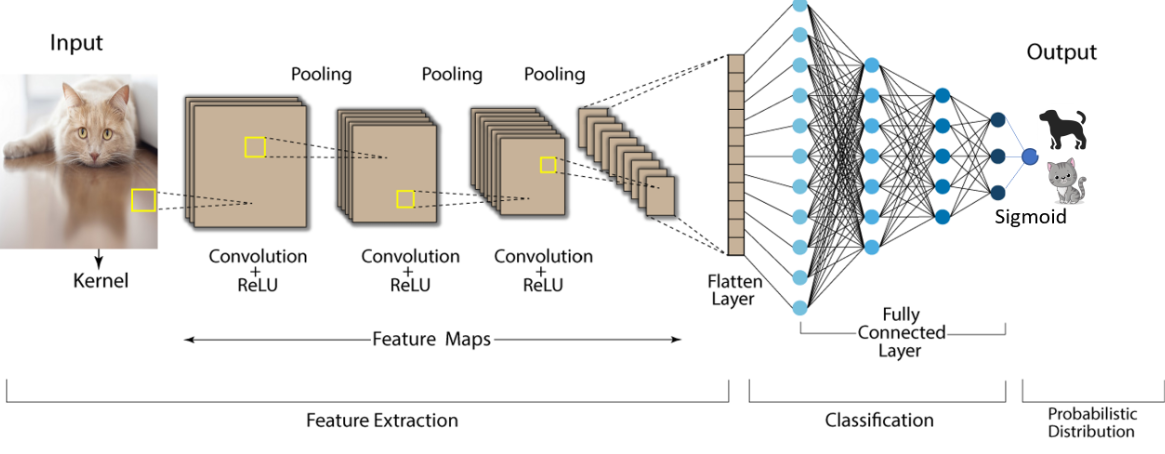

### Build 🪜

In [ ]:
class SimpleCNN(nn.Module):
   def __init__(self):
       super(SimpleCNN, self).__init__()
       self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
       self.pool1 = nn.MaxPool2d(2, 2)
       self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
       self.pool2 = nn.MaxPool2d(2, 2)
       self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
       self.pool3 = nn.MaxPool2d(2, 2)
       self.flatten = nn.Flatten()
       self.fc1 = nn.Linear(128 * 28 * 28, 128)
       self.fc2 = nn.Linear(128, 1)
       self.relu = nn.ReLU()
       self.sigmoid = nn.Sigmoid()

   def forward(self, x):
       x = self.pool1(self.relu(self.conv1(x)))
       x = self.pool2(self.relu(self.conv2(x)))
       x = self.pool3(self.relu(self.conv3(x)))
       x = self.flatten(x)
       x = self.relu(self.fc1(x))
       x = self.sigmoid(self.fc2(x))
       return x

# Create model and move to GPU
model = SimpleCNN().cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

print(model)

### Train 🏋️‍♂️

In [ ]:
# Reinitialize model weights
model = SimpleCNN().cuda()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Training loop with validation, early stopping, and history tracking
epochs = 20
patience = 5 # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

run_name="SimpleCNN_baseline"

with mlflow.start_run(run_name=run_name):
    # Log hyperparameters
    mlflow.log_params({
        "model_type": "SimpleCNN",
        "epochs": epochs,
        "patience": patience,
        "batch_size": 16,
        "optimizer": "Adam",
        "loss_function": "BCELoss",
        "data_augmentation": False,
        "learning_rate": 0.001
    })

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.cuda(), labels.float().cuda()

            optimizer.zero_grad()
            outputs = model(images).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (batch_idx + 1)
            current_acc = train_correct / train_total
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.4f}'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.cuda(), labels.float().cuda()
                outputs = model(images).squeeze(-1)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate final metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(valid_loader)

        # Store history
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print like TensorFlow
        print(f'accuracy: {train_acc:.4f} - loss: {train_loss_avg:.4f} - val_accuracy: {val_acc:.4f} - val_loss: {val_loss_avg:.4f}')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            # Store best model state and metrics
            best_model_state = model.state_dict().copy()
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_train_loss = train_loss_avg
            best_epoch = epoch + 1
            print('Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model and log to MLflow
    model.load_state_dict(best_model_state)

    # Test evaluation on best model
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.float().cuda()
            outputs = model(images).squeeze(-1)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    test_loss_avg = test_loss / len(test_loader)

    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss_avg:.5f}")

    # Log model and metrics to MLflow
    mlflow.pytorch.log_model(model, "SimpleCNN_baseline")

    # Log only the best model metrics
    mlflow.log_metrics({
        "best_train_accuracy": best_train_acc,
        "best_val_accuracy": best_val_acc,
        "best_train_loss": best_train_loss,
        "best_val_loss": best_val_loss,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss_avg,
        "best_epoch": best_epoch,
        "total_epochs_trained": epoch + 1
    })

    # Plot training history
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(train_losses, color='b', label='Training Loss')
    ax[0].plot(val_losses, color='r', label='Validation Loss')
    ax[0].set_title("Baseline CNN Model")
    ax[0].legend()
    ax[1].plot(train_accuracies, color='b', label='Training accuracy')
    ax[1].plot(val_accuracies, color='r', label='Validation accuracy')
    ax[1].legend()

    mlflow.log_figure(fig, f"{run_name}_training_history.png")
    plt.show()

    print('Training and testing completed!')

Our baseline CNN model is **memorizing the training data too well** but **struggling with new images**—yep, it's overfitting! 😅 It’s like a student who aces practice tests but gets confused in the real exam. Time to fine-tune and help our model **generalize better!** 🚀

### Improved CNN Baseline Model  🎯

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(50176, 512)  # Correct size: 256 * 14 * 14
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.bn1(self.relu(self.conv1(x))))
        x = self.pool2(self.bn2(self.relu(self.conv2(x))))
        x = self.pool3(self.bn3(self.relu(self.conv3(x))))
        x = self.pool4(self.bn4(self.relu(self.conv4(x))))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

model_improvedCNN = ImprovedCNN().cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_improvedCNN.parameters(), lr=0.0001)

print(model_improvedCNN)

In [ ]:
# Training loop with validation, early stopping, and history tracking
epochs = 20
patience = 5 # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

run_name = "ImprovedCNN_with_BatchNorm_Dropout"

with mlflow.start_run(run_name=run_name):
    # Log hyperparameters
    mlflow.log_params({
        "model_type": "ImprovedCNN",
        "epochs": epochs,
        "patience": patience,
        "batch_size": 16,
        "optimizer": "Adam",
        "loss_function": "BCELoss",
        "data_augmentation": False,
        "learning_rate": 0.0001,
        "batch_normalization": True,
        "dropout": 0.5,
        "conv_layers": 4,
        "fc1_units": 512
    })

    for epoch in range(epochs):
        # Training phase
        model_improvedCNN.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.cuda(), labels.float().cuda()

            optimizer.zero_grad()
            outputs = model_improvedCNN(images).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (batch_idx + 1)
            current_acc = train_correct / train_total
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.4f}'
            })

        # Validation phase
        model_improvedCNN.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.cuda(), labels.float().cuda()
                outputs = model_improvedCNN(images).squeeze(-1)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate final metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(valid_loader)

        # Store history
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print like TensorFlow
        print(f'accuracy: {train_acc:.4f} - loss: {train_loss_avg:.4f} - val_accuracy: {val_acc:.4f} - val_loss: {val_loss_avg:.4f}')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            # Store best model state and metrics
            best_model_state = model_improvedCNN.state_dict().copy()
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_train_loss = train_loss_avg
            best_epoch = epoch + 1
            print('Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model and test evaluation
    model_improvedCNN.load_state_dict(best_model_state)
    model_improvedCNN.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.float().cuda()
            outputs = model_improvedCNN(images).squeeze(-1)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    test_loss_avg = test_loss / len(test_loader)

    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss_avg:.5f}")

    # Log model and metrics to MLflow
    mlflow.pytorch.log_model(model_improvedCNN, "ImprovedCNN_model")

    # Log metrics
    mlflow.log_metrics({
        "best_train_accuracy": best_train_acc,
        "best_val_accuracy": best_val_acc,
        "best_train_loss": best_train_loss,
        "best_val_loss": best_val_loss,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss_avg,
        "best_epoch": best_epoch,
        "total_epochs_trained": epoch + 1
    })

    # Plot training history
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(train_losses, color='b', label='Training Loss')
    ax[0].plot(val_losses, color='r', label='Validation Loss')
    ax[0].set_title("Improved CNN with BatchNorm & Dropout")
    ax[0].legend()
    ax[1].plot(train_accuracies, color='b', label='Training accuracy')
    ax[1].plot(val_accuracies, color='r', label='Validation accuracy')
    ax[1].legend()

    mlflow.log_figure(fig, f"{run_name}_training_history.png")
    plt.show()

    print('Training and testing completed!')

Still some overfitting (training 99% vs validation 82%), but much more controlled. The improved model is actually learning generalizable patterns instead of just memorizing! To really break past 85-90%, we need something stronger! 💪 

Time to bring in transfer learning with VGG16 and MobileNetV2 and let the pre-trained models do the heavy lifting! 🚀🔥

## VGG16 📦

### Base model VGG116 🧩

In [ ]:
# Load pre-trained VGG16 with new syntax
base_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
# Remove the classifier (last layer)
base_model.classifier = nn.Sequential(*list(base_model.classifier.children())[:-1])
# Freeze convolutional layers
for param in base_model.features.parameters():
    param.requires_grad = False

class VGG16Model(nn.Module):
    def __init__(self):
        super(VGG16Model, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 256),  # VGG16 outputs 25088 features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.base_model.avgpool(x)
        x = self.classifier(x)
        return x

# Create model
model_vgg16 = VGG16Model().cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_vgg16.parameters())

print(model_vgg16)

In [ ]:
# Training loop with validation, early stopping, and history tracking
epochs = 20
patience = 5
best_val_loss = float('inf')
patience_counter = 0
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

run_name = "VGG16_transfer_learning"

with mlflow.start_run(run_name=run_name):
    # Log hyperparameters
    mlflow.log_params({
        "model_type": "VGG16",
        "epochs": epochs,
        "patience": patience,
        "batch_size": 16,
        "optimizer": "Adam",
        "loss_function": "BCELoss",
        "data_augmentation": False,
        "learning_rate": 0.001,  # Default Adam LR
        "transfer_learning": True,
        "pretrained_weights": "ImageNet",
        "frozen_layers": "All convolutional layers",
        "trainable_layers": "Custom classifier only",
        "classifier_units": 256,
        "dropout": 0.5
    })

    for epoch in range(epochs):
        # Training phase
        model_vgg16.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.cuda(), labels.float().cuda()

            optimizer.zero_grad()
            outputs = model_vgg16(images).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (batch_idx + 1)
            current_acc = train_correct / train_total
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.4f}'
            })

        # Validation phase
        model_vgg16.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.cuda(), labels.float().cuda()
                outputs = model_vgg16(images).squeeze(-1)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate final metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(valid_loader)

        # Store history
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print like TensorFlow
        print(f'accuracy: {train_acc:.4f} - loss: {train_loss_avg:.4f} - val_accuracy: {val_acc:.4f} - val_loss: {val_loss_avg:.4f}')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            # Store best model state and metrics
            best_model_state = model_vgg16.state_dict().copy()
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_train_loss = train_loss_avg
            best_epoch = epoch + 1
            print('Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model and test evaluation
    model_vgg16.load_state_dict(best_model_state)
    model_vgg16.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.float().cuda()
            outputs = model_vgg16(images).squeeze(-1)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    test_loss_avg = test_loss / len(test_loader)

    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss_avg:.5f}")

    # Log model and metrics to MLflow
    mlflow.pytorch.log_model(model_vgg16, "VGG16_model")

    # Log metrics
    mlflow.log_metrics({
        "best_train_accuracy": best_train_acc,
        "best_val_accuracy": best_val_acc,
        "best_train_loss": best_train_loss,
        "best_val_loss": best_val_loss,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss_avg,
        "best_epoch": best_epoch,
        "total_epochs_trained": epoch + 1
    })

    # Plot training history
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(train_losses, color='b', label='Training Loss')
    ax[0].plot(val_losses, color='r', label='Validation Loss')
    ax[0].set_title("VGG16 Transfer Learning Model")
    ax[0].legend()
    ax[1].plot(train_accuracies, color='b', label='Training accuracy')
    ax[1].plot(val_accuracies, color='r', label='Validation accuracy')
    ax[1].legend()

    mlflow.log_figure(fig, f"{run_name}_training_history.png")
    plt.show()

    print('Training and testing completed!')

VGG16 transfer learning achieved 96% validation accuracy with minimal overfitting - a massive improvement over custom CNNs! 

💪 Let’s enhance it with **data augmentation** and push beyond this barrier! 🚀🔥

### VGG16 with Data Augmentation 🎨

In [ ]:
# Data augmentation transforms
data_augmentation = transforms.Compose([
   transforms.RandomHorizontalFlip(),
   transforms.RandomRotation(degrees=36)  # 0.2 * 180 = 36 degrees
])

# Update your transform to include augmentation for training
train_transform = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.RandomHorizontalFlip(),
   transforms.RandomRotation(degrees=36),
   transforms.ToTensor(),
])

# Keep validation/test transform simple
val_test_transform = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
])

In [ ]:
# Take one batch from train_loader
for image_batch, label_batch in train_loader:
   sample_image = image_batch[0]  # Take first image from batch
   break

# Convert tensor to numpy and transpose from CHW to HWC
sample_image = sample_image.permute(1, 2, 0).numpy()

# Show original image
plt.figure(figsize=(5, 5))
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

In [ ]:
# Number of augmented images
num_augmented_images = 9

# Convert sample back to PIL for augmentation
sample_pil = transforms.ToPILImage()(image_batch[0])

# Create a figure
plt.figure(figsize=(9, 9))
for i in range(num_augmented_images):
   # Apply augmentation multiple times
   augmented_image = data_augmentation(sample_pil)
   # Convert to tensor then numpy for display
   augmented_tensor = transforms.ToTensor()(augmented_image)
   augmented_numpy = augmented_tensor.permute(1, 2, 0).numpy()

   # Display each augmented image
   plt.subplot(3, 3, i + 1)
   plt.imshow(augmented_numpy)
   plt.axis("off")  # Remove axis labels
plt.show()

We’ve set up **data augmentation**, and now it’s time to put it to work! 

💪 Let’s use it with **VGG16 fine-tuning** and see if we can finally push our accuracy! 🚀🔥

In [ ]:
# Recreate datasets and loaders HERE
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
# Load pre-trained VGG16 with fine-tuning
base_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Unfreeze only the last 4 layers (fine-tuning)
for param in base_model.features[:-8].parameters():  # Freeze early layers
   param.requires_grad = False
for param in base_model.features[-8:].parameters():  # Unfreeze last layers
   param.requires_grad = True

class VGG16_DA_Model(nn.Module):
   def __init__(self):
       super(VGG16_DA_Model, self).__init__()
       self.base_model = base_model
       self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
       self.classifier = nn.Sequential(
           nn.Flatten(),
           nn.Linear(512, 256),  # VGG16 features output 512 channels
           nn.ReLU(),
           nn.Dropout(0.5),
           nn.Linear(256, 1),
           nn.Sigmoid()
       )

   def forward(self, x):
       x = self.base_model.features(x)
       x = self.global_avg_pool(x)
       x = self.classifier(x)
       return x

# Create model with fine-tuning
model_vgg16_da = VGG16_DA_Model().cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_vgg16_da.parameters(), lr=1e-4)

print(model_vgg16_da)

In [ ]:
# Training loop with validation, early stopping, and history tracking
epochs = 20
patience = 5
best_val_loss = float('inf')
patience_counter = 0
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

run_name = "VGG16_with_DA_FT"

with mlflow.start_run(run_name=run_name):
    # Log hyperparameters
    mlflow.log_params({
        "model_type": "VGG16_DA_FineTuned",
        "epochs": epochs,
        "patience": patience,
        "batch_size": 16,
        "optimizer": "Adam",
        "loss_function": "BCELoss",
        "data_augmentation": True,
        "augmentation_types": "RandomHorizontalFlip, RandomRotation(36°)",
        "learning_rate": 1e-4,
        "transfer_learning": True,
        "pretrained_weights": "ImageNet",
        "fine_tuning": True,
        "frozen_layers": "First 18 conv layers",
        "trainable_layers": "Last 8 conv layers + custom classifier",
        "classifier_units": 256,
        "dropout": 0.5,
        "global_pooling": "AdaptiveAvgPool2d"
    })

    for epoch in range(epochs):
        # Training phase
        model_vgg16_da.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.cuda(), labels.float().cuda()

            optimizer.zero_grad()
            outputs = model_vgg16_da(images).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (batch_idx + 1)
            current_acc = train_correct / train_total
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.4f}'
            })

        # Validation phase
        model_vgg16_da.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.cuda(), labels.float().cuda()
                outputs = model_vgg16_da(images).squeeze(-1)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate final metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(valid_loader)

        # Store history
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print like TensorFlow
        print(f'accuracy: {train_acc:.4f} - loss: {train_loss_avg:.4f} - val_accuracy: {val_acc:.4f} - val_loss: {val_loss_avg:.4f}')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            # Store best model state and metrics
            best_model_state = model_vgg16_da.state_dict().copy()
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_train_loss = train_loss_avg
            best_epoch = epoch + 1
            print('Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print('No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print('Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model and test evaluation
    model_vgg16_da.load_state_dict(best_model_state)
    model_vgg16_da.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.float().cuda()
            outputs = model_vgg16_da(images).squeeze(-1)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    test_loss_avg = test_loss / len(test_loader)

    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss_avg:.5f}")

    # Log model and metrics to MLflow
    mlflow.pytorch.log_model(model_vgg16_da, "VGG16_DA_FT_model")

    # Log metrics
    mlflow.log_metrics({
        "best_train_accuracy": best_train_acc,
        "best_val_accuracy": best_val_acc,
        "best_train_loss": best_train_loss,
        "best_val_loss": best_val_loss,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss_avg,
        "best_epoch": best_epoch,
        "total_epochs_trained": epoch + 1
    })

    # Plot training history
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(train_losses, color='b', label='Training Loss')
    ax[0].plot(val_losses, color='r', label='Validation Loss')
    ax[0].set_title("VGG16 with Data Augmentation & Fine-tuning")
    ax[0].legend()
    ax[1].plot(train_accuracies, color='b', label='Training accuracy')
    ax[1].plot(val_accuracies, color='r', label='Validation accuracy')
    ax[1].legend()

    mlflow.log_figure(fig, f"{run_name}_training_history.png")
    plt.show()

    print('Training and testing completed!')

Boom! 💥 **98% accuracy** with fine-tuned VGG16! 🎉 

Now, let’s see if we can **push it even further** with **MobileNetV2**—a lighter, faster model that might just surprise us! 🚀🔥

## MobileNetV2 With Augmentation 🎨

In [ ]:
# Load pre-trained MobileNetV2 (frozen weights)
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Freeze all layers
for param in base_model.parameters():
   param.requires_grad = False

class MobileNetV2_Model(nn.Module):
   def __init__(self):
       super(MobileNetV2_Model, self).__init__()
       # Remove the classifier from MobileNetV2
       self.features = base_model.features
       self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
       self.classifier = nn.Sequential(
           nn.Flatten(),
           nn.Linear(1280, 256),  # MobileNetV2 outputs 1280 channels
           nn.ReLU(),
           nn.Dropout(0.2),
           nn.Linear(256, 1),
           nn.Sigmoid()
       )

   def forward(self, x):
       x = self.features(x)
       x = self.global_avg_pool(x)
       x = self.classifier(x)
       return x

# Create model
model_mobilev2 = MobileNetV2_Model().cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_mobilev2.parameters(), lr=1e-4)

In [ ]:
# Training loop with validation, early stopping, and history tracking
epochs = 20
patience = 5
best_val_loss = float('inf')
patience_counter = 0
# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

run_name = "MobileNetV2"

with mlflow.start_run(run_name=run_name):
    # Log hyperparameters
    mlflow.log_params({
        "model_type": "MobileNetV2",
        "epochs": epochs,
        "patience": patience,
        "batch_size": 16,
        "optimizer": "Adam",
        "loss_function": "BCELoss",
        "data_augmentation": True,  # Using augmented data loaders
        "learning_rate": 1e-4,
        "transfer_learning": True,
        "pretrained_weights": "ImageNet",
        "frozen_layers": "All feature layers",
        "trainable_layers": "Custom classifier only",
        "classifier_units": 256,
        "dropout": 0.2,
        "global_pooling": "AdaptiveAvgPool2d",
        "model_efficiency": "Mobile-optimized architecture",
        "input_channels": 1280
    })

    for epoch in range(epochs):
        # Training phase
        model_mobilev2.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.cuda(), labels.float().cuda()

            optimizer.zero_grad()
            outputs = model_mobilev2(images).squeeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (batch_idx + 1)
            current_acc = train_correct / train_total
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.4f}'
            })

        # Validation phase
        model_mobilev2.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.cuda(), labels.float().cuda()
                outputs = model_mobilev2(images).squeeze(-1)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate final metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(valid_loader)

        # Store history
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print like TensorFlow
        print(f'accuracy: {train_acc:.4f} - loss: {train_loss_avg:.4f} - val_accuracy: {val_acc:.4f} - val_loss: {val_loss_avg:.4f}')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            # Store best model state and metrics
            best_model_state = model_mobilev2.state_dict().copy()
            best_train_acc = train_acc
            best_val_acc = val_acc
            best_train_loss = train_loss_avg
            best_epoch = epoch + 1
            print('Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model and test evaluation
    model_mobilev2.load_state_dict(best_model_state)
    model_mobilev2.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.float().cuda()
            outputs = model_mobilev2(images).squeeze(-1)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    test_loss_avg = test_loss / len(test_loader)

    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss_avg:.5f}")

    # Log model and metrics to MLflow
    mlflow.pytorch.log_model(model_mobilev2, "MobileNetV2_model")

    # Log metrics
    mlflow.log_metrics({
        "best_train_accuracy": best_train_acc,
        "best_val_accuracy": best_val_acc,
        "best_train_loss": best_train_loss,
        "best_val_loss": best_val_loss,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss_avg,
        "best_epoch": best_epoch,
        "total_epochs_trained": epoch + 1
    })

    # Plot training history
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(train_losses, color='b', label='Training Loss')
    ax[0].plot(val_losses, color='r', label='Validation Loss')
    ax[0].set_title("MobileNetV2 Transfer Learning")
    ax[0].legend()
    ax[1].plot(train_accuracies, color='b', label='Training accuracy')
    ax[1].plot(val_accuracies, color='r', label='Validation accuracy')
    ax[1].legend()

    mlflow.log_figure(fig, f"{run_name}_training_history.png")
    plt.show()

    print('Training and testing completed!')

- VGG16: Higher test accuracy (98%) but overfitting badly
- MobileNetV2: Slightly lower accuracy (97%) but much better generalization

MobileNetV2 is the better model, it will perform more reliably on new, unseen data. The VGG16's 98% might be inflated due to overfitting.

## Predictions 🔮

In [ ]:
# Load the best model from MLflow (replace with your actual run ID)
# You can get the run ID from MLflow UI or use: mlflow.active_run().info.run_id
run_id = "40473a3d0d364a1e8b709d1a063db5a5"  # Replace with actual MobileNetV2 run ID
model_uri = f"runs:/{run_id}/MobileNetV2_model"
model_mobilev2 = mlflow.pytorch.load_model(model_uri)
model_mobilev2 = model_mobilev2.cuda()
model_mobilev2.eval()

In [ ]:
# Define the number of images you want to display
num_images = 5
# Create a 1-row, num_images-column grid for displaying images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Get random samples directly from dataset (ensures mix of cats/dogs)
random_indices = random.sample(range(len(test_dataset)), num_images)
images_list = []
labels_list = []

for idx in random_indices:
    img, label = test_dataset[idx]
    images_list.append(img)
    labels_list.append(label)

images = torch.stack(images_list)
labels = torch.tensor(labels_list)

# Move to GPU and get predictions
images_gpu = images.cuda()
with torch.no_grad():
    outputs = model_mobilev2(images_gpu).squeeze(-1)
    predicted_probs = outputs.cpu().numpy()
    predicted_labels = (predicted_probs >= 0.5).astype(int)

# Display images with predictions
for i in range(num_images):
    ax = axes[i]
    img_np = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img_np)

    actual_label = 'Cat' if labels[i].item() == 0 else 'Dog'
    predicted_label = 'Cat' if predicted_labels[i] == 0 else 'Dog'
    confidence = predicted_probs[i] if predicted_labels[i] == 1 else (1 - predicted_probs[i])

    ax.set_title(f"Actual: {actual_label} | Pred: {predicted_label}\nConf: {confidence:.3f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Confusion Matrix - Classification report 🟠🔵

In [ ]:
# Lists to store true and predicted labels for confusion matrix
y_true = []
y_pred = []

print("Generating predictions for confusion matrix...")

# Iterate through all test data to get true labels and predictions
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()

        # Get predictions
        outputs = model_mobilev2(images).squeeze(-1)
        predicted_probs = outputs.cpu().numpy()
        predicted_labels = (predicted_probs >= 0.5).astype(int)

        # Collect true labels and predicted labels
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MobileNetV2 Cat/Dog Classification')
plt.show()

# Print classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

97% accuracy across the board with perfect balance:

- ✅ Precision & Recall: Both 97% for cats AND dogs
- ✅ Balanced performance: No bias toward either class
- ✅ Consistent F1-scores: 0.97 for both classes
- ✅ Equal test samples: 1011 cats, 1012 dogs (perfectly balanced)

## Run Inference ⚡

### Predict from an Image URL 🔮

In [ ]:
# Define preprocessing transform
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def preprocess_image_from_url(url):
    """Download and preprocess image from URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img, img_tensor

def make_prediction(img_tensor, model, threshold=0.6):
    """Make prediction using PyTorch model"""
    model.eval()
    with torch.no_grad():
        img_gpu = img_tensor.cuda()
        output = model(img_gpu).squeeze(-1)
        prediction = output.cpu().item()

    confidence = abs(prediction - 0.5) * 2
    if confidence < 0.4:
        most_likely_label = "Cat" if prediction < 0.5 else "Dog"
        return f"Uncertain: {most_likely_label}", confidence

    predicted_label = "Cat" if prediction < 0.5 else "Dog"
    return predicted_label, confidence

def display_prediction(img, predicted_label, confidence):
    """Display image with prediction"""
    plt.imshow(img)
    plt.title(f"{predicted_label} ({confidence*100:.1f}% confidence)")
    plt.axis("off")
    plt.show()

In [ ]:
def predict_image_from_url(url, model):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        if "image" not in response.headers.get("Content-Type", ""):
            print("Error: URL does not contain a valid image.")
            return None

        img = Image.open(BytesIO(response.content)).convert("RGB")
        img_tensor = preprocess(img).unsqueeze(0)  # Use PyTorch preprocess

        predicted_label, confidence = make_prediction(img_tensor, model)  # Use PyTorch prediction
        display_prediction(img, predicted_label, confidence)
        return predicted_label

    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

In [ ]:
url = "https://vetmarlborough.co.nz/wp-content/uploads/cat-facts.jpg"
predict_image_from_url(url, model_mobilev2)

In [ ]:
url = "https://radiomontblanc.fr/photos/articles/vignettes/fromage-pyrenees-bethmale_47828.jpg"
predict_image_from_url(url, model_mobilev2)

In [ ]:
url = "https://lacvets.com/wp-content/uploads/2021/05/dog-sneezing-in-lakeland-fl-300x279.jpg"
predict_image_from_url(url, model_mobilev2)

In [ ]:
url = "https://petzpark.com.au/cdn/shop/articles/Dog-and-Cat-Stress_900x.jpg?v=1660605269"
predict_image_from_url(url, model_mobilev2)